In [1]:
import fnmatch
import os
import pprint
from tqdm import tqdm
import numpy as np
import pandas as pd
import scipy.io as sio
from sklearn.decomposition import PCA
from analysis_clustering_helpers import parse_dend, plot_htree, do_merges, \
                                        get_cvfold, predict_leaf_gmm, get_cca_projections, get_cvfold_extended


cvsets_pth    = './data/results/patchseq/'
metadata_file = './data/raw/PS_v2_beta_0-4.mat'
htree_file    = './data/raw/dend_RData_Tree_20181220.csv'

**Initializations and parameters for supervised clustering analysis**

In [ ]:
matfile   = sio.loadmat(metadata_file,squeeze_me=True)

#Load hierarchical tree attributes
list_changes, descendants, treeobj, leaves, child, parent  = parse_dend(htree_file=htree_file)

#Parameters used for the supervised accuracy calculations
min_merges   = 0
max_merges   = 83
n_merge_step = 5
train_gmm_on = ['T_z','E_z']
test_gmm_on  = ['T_z','E_z']
train_on     = 'original_labels'

#Parameters for label prediction
n_per_class_thr=6
diag_cov_n_sample_thr=12

#Initialize
D={}
for i in range(len(train_gmm_on)):
    D[train_gmm_on[i]+'_'+test_gmm_on[i]]=[]

#Loading a single dataset to calculate some constant values used later
csval='100-0'
file_list = sorted([file for file in os.listdir(cvsets_pth) if 'cs_'+csval+'_' in file])
file_list = [file for file in file_list if '.mat' in file]
_,_,train_leaf,val_leaf = get_cvfold(cvfile=cvsets_pth+file_list[0],refdata=matfile)
all_labels = np.concatenate([train_leaf['labels'],val_leaf['labels']])
temp_label,count_array = np.unique(all_labels,return_counts=True)
counts = np.zeros(np.shape(leaves))

#Calculate relative abundance to determine weights
for i,ll in enumerate(leaves):
    ind = np.isin(temp_label,ll)
    if np.sum(ind)>0:
        counts[i]=count_array[ind]
    else:
        pass
unique_leaf_weights = counts/np.sum(counts)

**PCA-CCA analysis**
 - Can use below section to perform PCA followed by CCA on the raw data matrices. 
 - Use 3D representations from coupled autoencoders, or those obtained with PCA-CCA to perform supervised clustering with QDA. 

Note: The PCA-CCA transformations are performed on paired data that were mapped to leaf nodes on the transcriptomic hierarchy => baseline has an 'unfair' advantage.

In [ ]:
#Loads the cross validation sets for one of the coupling strengths. 
#This is only used to get the indices for training and validation data, 
#and coupling strength plays no role in these baseline calculations.
csval='100-0'
file_list = sorted([file for file in os.listdir(cvsets_pth) if 'cs_'+csval+'_' in file])
file_list = [file for file in file_list if '.mat' in file]

#All the supervised clustering results can be obtained by changed the 
pca = PCA(n_components=10)
for f,file in enumerate(tqdm(file_list)):
    
    if csval=='100-0':
        #Load the raw data:
        _,_,train_leaf,val_leaf = get_cvfold_extended(cvfile=cvsets_pth+file,refdata=matfile,full_data=True)

        #Reduce dimensionality with PCA here:
        train_leaf['T_x'] = pca.fit_transform(train_leaf['T_x'])
        val_leaf['T_x'] = pca.transform(val_leaf['T_x'])
        train_leaf['E_x'] = pca.fit_transform(train_leaf['E_x'])
        val_leaf['E_x'] = pca.transform(val_leaf['E_x'])
        
        #Align with CCA:
        train_leaf,val_leaf = get_cca_projections(train_leaf,val_leaf,n_components=3)
    else:
        _,_,train_leaf,val_leaf = get_cvfold(cvfile=cvsets_pth+file,refdata=matfile)
   
    for m in range(min_merges,max_merges,n_merge_step):
        #Merge leaf nodes on existing htree, and obtain the new leaf labels.
        merged_labels = do_merges(labels=leaves.copy(), list_changes=list_changes, n_merges=m)
        unique_merged_labels = np.unique(merged_labels).tolist()
        descendants_for_merged_labels = {key: descendants[key] for key in unique_merged_labels}

        for i in range(len(train_gmm_on)):
            true_test_lbl, pred_test_lbl, n_excluded_cells, n_classes_predicted, n_classes_removed, pred_probability = \
                                predict_leaf_gmm(train_z=train_leaf[train_gmm_on[i]].copy(),
                                                 true_train_lbl=train_leaf['labels'].copy(),
                                                 test_z=val_leaf[test_gmm_on[i]].copy(),
                                                 true_test_lbl=val_leaf['labels'],
                                                 n_per_class_thr=n_per_class_thr, diag_cov_n_sample_thr = diag_cov_n_sample_thr,
                                                 unique_dataset_lbl=unique_merged_labels,
                                                 unique_leaf_lbl=leaves.copy(),
                                                 descendant_dict=descendants_for_merged_labels,
                                                 label_weight=[])
            
            D[train_gmm_on[i]+'_'+test_gmm_on[i]].append([f,m,n_classes_predicted,n_classes_removed,true_test_lbl,pred_test_lbl,pred_probability])

**Error bar calculations**
 - Calculate errors over cross validation sets
 - Compile and save .csv files for plotting

In [ ]:
#Initialize
Plot_Data={}
Labels={}
Prob={'T_z_T_z':{},'T_z_E_z':{},'E_z_E_z':{},'E_z_T_z':{}}

for i in range(len(train_gmm_on)):    
    x_data=[]
    y_data=[]
    acc_mean = []
    acc_err = []
    exc_data=[]

    #For each number of merge steps, collect prediction results over cvsets
    for m in range(min_merges,max_merges,n_merge_step):
        true_list=[]
        pred_list=[]
        prob_list=[]
        acc_list=[]
        n_classes_pred=[]
        n_classes_excl=[]

        for result in D[train_gmm_on[i]+'_'+test_gmm_on[i]]:
            if result[1]==m:
                n_classes_pred.append(result[2])
                n_classes_excl.append(result[3])
                true_list.extend(result[4])
                pred_list.extend(result[5])
                #pdb.set_trace()
                acc_list.append(np.sum(result[5]==result[4])/result[5].size)
                prob_list.extend(result[6])
                
        true_array = np.array(true_list)
        pred_array = np.array(pred_list)
        prob_array = np.array(prob_list)
        acc_arr =  np.array(acc_list)
        excluded = np.mean(n_classes_excl)
        
        true_lbl = true_array
        pred_lbl = pred_array
        acc = 100*np.sum(pred_lbl==true_lbl)/np.size(true_lbl)
        
        remain_n_classes = np.unique(true_lbl).size
        Labels[str(remain_n_classes)]={}
        Labels[str(remain_n_classes)][train_gmm_on[i]+'_'+test_gmm_on[i]]={}
        Labels[str(remain_n_classes)][train_gmm_on[i]+'_'+test_gmm_on[i]]['true']=true_lbl
        Labels[str(remain_n_classes)][train_gmm_on[i]+'_'+test_gmm_on[i]]['pred']=pred_lbl
        Labels[str(remain_n_classes)][train_gmm_on[i]+'_'+test_gmm_on[i]]['prob']=prob_array
        
        Prob[train_gmm_on[i]+'_'+test_gmm_on[i]][str(remain_n_classes)]=prob_array
        
        acc_mean.append(np.mean(acc_arr))
        acc_err.append(np.std(acc_arr)/np.sqrt(acc_arr.size))
        x_data.append(remain_n_classes)
        y_data.append(np.round(acc,decimals=2))
        exc_data.append(excluded)
    
    Plot_Data[train_gmm_on[i]+'_'+test_gmm_on[i]]=(np.array(x_data),
                                                   np.array(y_data),
                                                   np.array(exc_data),
                                                   np.array(acc_mean),
                                                   np.array(acc_err))
    
    dataset = pd.DataFrame({'remain_classes':np.array(x_data),
                            'accuracy':np.array(y_data),
                            'acc_mean':np.array(acc_mean)*100,
                            'acc_err':np.array(acc_err)*100})
    filepath='/home/rohan/Dropbox/AllenInstitute/CellTypes/dat/result/supervised_clustering_perfold/'
    filename=train_gmm_on[i]+'_'+test_gmm_on[i]+'_'+'10-10-pca-3-cca.csv'
    dataset.to_csv(filepath+filename,index=False)

**Figures 3A and 3B:**  Cross-validated accuracy of quadratic classifiers trained on transcriptomic (A) and electrophysiology (B) representations in predicting transcriptomic cell classes at different resolutions of the hierarchy.

In [1]:
%matplotlib inline

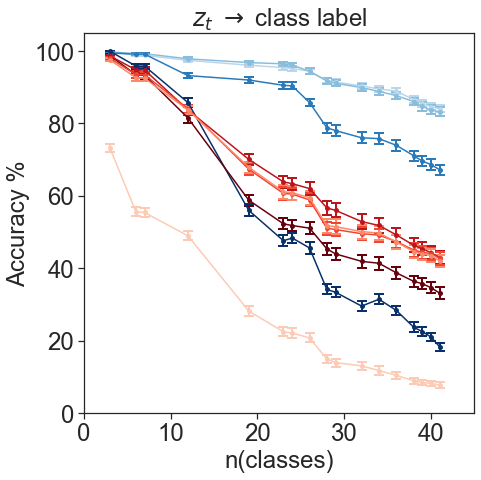

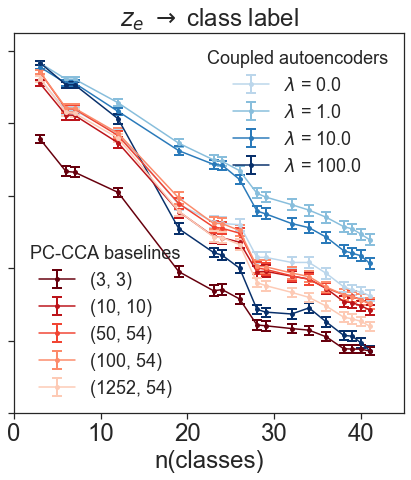

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
sns.set()
sns.set_style('ticks',{'axes.grid' : False})

D = {}
filepath='./data/results/supervised_clustering_perfold/'
cslist = ['0-0','1-0','10-0','100-0']
cs_val = ['0.0','1.0','10.0','100.0']

#Specify colors for autoencoder plots
cols=plt.get_cmap('Blues_r',lut=8)
col_list=[cols(0),cols(2),cols(4),cols(5)]
col_list.reverse()

#Plot initializations
fig_3A = plt.figure(figsize=(7,7))
ax_3A = plt.subplot(1,1,1)
fig_3B = plt.figure(figsize=(7,7))
ax_3B = plt.subplot(1,1,1)
ae_legend_txt = []
ae_plot_list = []

legend_txt_size = 18
ax_txt_size = 24

#Autoencoder plots with different coupling strengths:----------------------------------
for i,cs in enumerate(cslist):
    col = col_list[i]
    plot_props = {'fmt': '.-', 'c': col, 'mfc': col, 'ms': 10, 'mec': 'None',  'mew': 2,
                  'ecolor': col, 'elinewidth': 2, 'capsize': 5,
                  'label': r'$\lambda$ = '+cs_val[i]}

    plt.sca(ax_3A)
    TT = pd.read_csv(filepath+'T_z_T_z_'+cs+'.csv')
    plt_TT_ae = plt.errorbar(TT['remain_classes'],
                             TT['acc_mean'],
                             TT['acc_err'],
                             **plot_props)
    
    plt.sca(ax_3B)
    EE = pd.read_csv(filepath+'E_z_E_z_'+cs+'.csv')
    plt_EE_ae = plt.errorbar(EE['remain_classes'],
                             EE['acc_mean'],
                             EE['acc_err'],
                             **plot_props)
    
    ae_legend_txt.append(r'$\lambda$ = '+cs_val[i])
    ae_plot_list.append(plt_TT_ae)

#CCA after PCA plots:------------------------------------------------------------------
col_list = plt.get_cmap('Reds_r',lut=6)
file_id = ['3-3-pca-3-cca','10-10-pca-3-cca','50-51-pca-3-cca','100-51-pca-3-cca','cca']
baseline_legend_txt = ['(3, 3)','(10, 10)','(50, 54)','(100, 54)','(1252, 54)']
plotlist = []
for i in [0, 1, 2, 3, 4]:
    col = col_list(i)
    plot_props = {'fmt': '.-', 'c': col, 'mfc': col, 'ms': 10, 'mec': 'None',  'mew': 2,
                  'ecolor': col, 'elinewidth': 2, 'capsize': 5,
                  'label': baseline_legend_txt[i]}

    plt.sca(ax_3A)
    TT_baseline = pd.read_csv(filepath+'T_z_T_z_'+file_id[i]+'.csv')
    plt_TT_baseline = plt.errorbar(TT_baseline['remain_classes'],
                                   TT_baseline['acc_mean'],
                                   TT_baseline['acc_err'],
                                   **plot_props)

    plt.sca(ax_3B)
    EE_baseline = pd.read_csv(filepath+'E_z_E_z_'+file_id[i]+'.csv')
    plt_EE_baseline = plt.errorbar(EE_baseline['remain_classes'],
                                   EE_baseline['acc_mean'],
                                   EE_baseline['acc_err'],
                                   **plot_props)

    plotlist.append(plt_EE_baseline)

ax_3A.set_title(r'$z_{t}$ $\rightarrow$ class label')
ax_3A.set_xlim(0,45)
ax_3A.set_xticks(np.arange(0,45,10))
ax_3A.set_xlabel('n(classes)')

ax_3A.set_ylim(0,105)
ax_3A.set_yticks(np.arange(0,101,20))
ax_3A.set_ylabel('Accuracy %')

ax_3B.set_title(r'$z_{e}$ $\rightarrow$ class label')
ax_3B.set_xlabel('n(classes)')
ax_3B.set_xlim(0,45)
ax_3B.set_xticks(np.arange(0,45,10))

ax_3B.set_ylim(0,105)
ax_3B.yaxis.set_ticklabels([])
legend_ae = ax_3B.legend(ae_plot_list,ae_legend_txt,prop={'size': legend_txt_size},loc='upper right',frameon=False)
legend_ae.set_title('Coupled autoencoders')

legend_baselines = ax_3B.legend(plotlist,baseline_legend_txt,prop={'size': legend_txt_size},loc='lower left',frameon=False)
legend_baselines.set_title('PC-CCA baselines')

# Manually add the first legend back
ax_3B.add_artist(legend_ae)
legend_ae.get_title().set_fontsize(legend_txt_size)
legend_baselines.get_title().set_fontsize(legend_txt_size)

for item in ([ax_3A.title, ax_3A.xaxis.label, ax_3A.yaxis.label] +
             ax_3A.get_xticklabels() + ax_3A.get_yticklabels()):
    item.set_fontsize(ax_txt_size)

for item in ([ax_3B.title, ax_3B.xaxis.label, ax_3B.yaxis.label] +
             ax_3B.get_xticklabels() + ax_3B.get_yticklabels()):
    item.set_fontsize(ax_txt_size)


fig_3A.savefig('/Users/fruity/Dropbox/AllenInstitute/CellTypes/doc/NeurIPS 2019/camready/Fig3A.pdf',
               dpi=300, format='pdf', bbox_inches='tight')

fig_3B.savefig('/Users/fruity/Dropbox/AllenInstitute/CellTypes/doc/NeurIPS 2019/camready/Fig3B.pdf',
               dpi=300, format='pdf', bbox_inches='tight')

**Figure 3C**: Unsupervised clustering consistency. 

 - Checks to test consistency of clusters are across T and E modalities for different $\lambda_{coupling}$. 

Algorithm:
 - for each cross validation set:
 - fit GMM to $z_{T}^{train}$
 - obtain $L_{true}^{test}$ using the GMM fit to determine labels with $z_{T}^{test}$
 - obtain $L_{pred}^{test}$ using the GMM fit, but now using $z_{E}^{test}$ 
 - Compare labels with ARI and AMI to quantify clustering similarity
 - Average ARI and AMI are reported in th manuscript

Implementation notes:
 - Results are written to csv files by `analysis_clustering_unsupervised.py`

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
sns.set_style('ticks',{'axes.grid' : False})

In [6]:
#Read in results files
result_path = './data/results/unsupervised_clustering/'

#set headers as f,m,ari, ami here.
cae_0_ET = pd.read_csv(result_path+'cae_E_z_T_z_cs_0-0.csv',header=None,names=['fileind','n_clusters','ari','ami'])
cae_0_TE = pd.read_csv(result_path+'cae_T_z_E_z_cs_0-0.csv',header=None,names=['fileind','n_clusters','ari','ami'])

cae_1_ET = pd.read_csv(result_path+'cae_E_z_T_z_cs_1-0_run_1.csv',header=None,names=['fileind','n_clusters','ari','ami'])
cae_1_TE = pd.read_csv(result_path+'cae_T_z_E_z_cs_1-0_run_1.csv',header=None,names=['fileind','n_clusters','ari','ami'])

cae_10_ET = pd.read_csv(result_path+'cae_E_z_T_z_cs_10-0.csv',header=None,names=['fileind','n_clusters','ari','ami'])
cae_10_TE = pd.read_csv(result_path+'cae_T_z_E_z_cs_10-0.csv',header=None,names=['fileind','n_clusters','ari','ami'])

cae_100_ET = pd.read_csv(result_path+'cae_E_z_T_z_cs_100-0.csv',header=None,names=['fileind','n_clusters','ari','ami'])
cae_100_TE = pd.read_csv(result_path+'cae_T_z_E_z_cs_100-0.csv',header=None,names=['fileind','n_clusters','ari','ami'])

cca_0_ET = pd.read_csv(result_path+'cca_E_z_T_z_cs_0-0.csv',header=None,names=['fileind','n_clusters','ari','ami'])
cca_0_TE = pd.read_csv(result_path+'cca_T_z_E_z_cs_0-0.csv',header=None,names=['fileind','n_clusters','ari','ami'])


#PCA with CCA files:
pca_3_3_ET = pd.read_csv(result_path+'cca_E_z_T_z_3_3_cca.csv',header=None,names=['fileind','n_clusters','ari','ami'])
pca_3_3_TE = pd.read_csv(result_path+'cca_T_z_E_z_3_3_cca.csv',header=None,names=['fileind','n_clusters','ari','ami'])

pca_10_10_ET = pd.read_csv(result_path+'cca_E_z_T_z_10_10_cca.csv',header=None,names=['fileind','n_clusters','ari','ami'])
pca_10_10_TE = pd.read_csv(result_path+'cca_T_z_E_z_10_10_cca.csv',header=None,names=['fileind','n_clusters','ari','ami'])

pca_50_54_ET = pd.read_csv(result_path+'cca_E_z_T_z_50_0_cca.csv',header=None,names=['fileind','n_clusters','ari','ami'])
pca_50_54_TE = pd.read_csv(result_path+'cca_T_z_E_z_50_0_cca.csv',header=None,names=['fileind','n_clusters','ari','ami'])

pca_100_54_ET = pd.read_csv(result_path+'cca_E_z_T_z_100_0_cca.csv',header=None,names=['fileind','n_clusters','ari','ami'])
pca_100_54_TE = pd.read_csv(result_path+'cca_T_z_E_z_100_0_cca.csv',header=None,names=['fileind','n_clusters','ari','ami'])

pca_0_0_ET = pd.read_csv(result_path+'cca_E_z_T_z_0_0_cca.csv',header=None,names=['fileind','n_clusters','ari','ami'])
pca_0_0_TE = pd.read_csv(result_path+'cca_T_z_E_z_0_0_cca.csv',header=None,names=['fileind','n_clusters','ari','ami'])

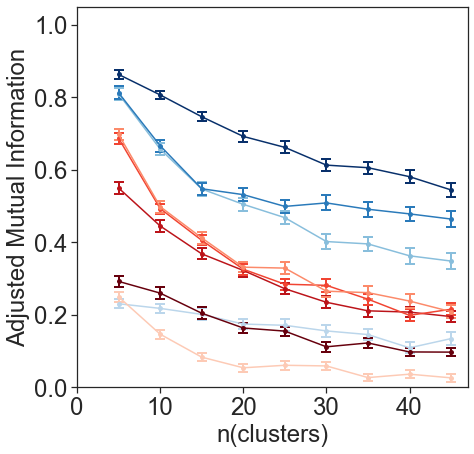

In [7]:
df_list = [cae_0_ET,
           cae_1_ET,
           cae_10_ET,
           cae_100_ET,
           pca_3_3_ET,
           pca_10_10_ET,
           pca_50_54_ET,
           pca_100_54_ET,
           cca_0_ET]

legend_txt = [r'$\lambda = 0$',
              r'$\lambda = 1.0$',
              r'$\lambda = 10.0$',
              r'$\lambda = 100.0$',
              r'(3,3)',
              r'(10,10)',
              r'(50,54)',
              r'(100,54)',
              r'(1252,54)']

measure = 'ami'

cols=plt.get_cmap('Blues_r',lut=8)
col_list=[cols(0),cols(2),cols(4),cols(5)]
col_list.reverse()
cols = plt.get_cmap('Reds_r',lut=6)
col_list.extend([cols(0),cols(1),cols(2),cols(3),cols(4)])
legend_txt_size = 18
ax_txt_size = 24

fig_3C = plt.figure(figsize=(7,7))
for i,df in enumerate(df_list):
    X=[]
    Y=[]
    E=[]
    for n_clusters in np.unique(df['n_clusters']):
        X.append(n_clusters)
        vals = df[measure].loc[df['n_clusters']==n_clusters].values 
        #Average and S.E. values over cross validation sets:
        Y.append(np.mean(vals))
        E.append(np.std(vals)/np.sqrt(np.size(vals)))

    col = col_list[i]
    plt.errorbar(X, Y, yerr=E,
                 fmt='.-', c=col, mfc=col, ms=10, mec='None',  mew=2,
                 ecolor=col, elinewidth=2, capsize=5,
                 label=legend_txt[i])

ax_3C = plt.gca()
ax_3C.set_xlabel('n(clusters)')
ax_3C.set_ylabel('Adjusted Mutual Information')
ax_3C.set_ylim(0,1.05)
ax_3C.set_xlim(0,47)
ax_3C.set_xticks([0,10,20,30,40])

for item in ([ax_3C.title, ax_3C.xaxis.label, ax_3C.yaxis.label] +
             ax_3C.get_xticklabels() + ax_3C.get_yticklabels()):
    item.set_fontsize(ax_txt_size)
    
fig_3C.savefig('/Users/fruity/Dropbox/AllenInstitute/CellTypes/doc/NeurIPS 2019/camready/Fig3C.pdf',
               dpi=300, format='pdf', bbox_inches='tight')